# COVID-19 Lung Leision Segmentation

In [1]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score

# append project directory to path
import sys
project_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(project_dir, "data")
model_dir = os.path.join(project_dir, "model")
sys.path.append(project_dir)
print(f"project directory: {project_dir}")
print(f"data directory: {data_dir}")
print(f"model directory: {model_dir}")

project directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation
data directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation/data
model directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation/model


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# check gpu
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

# seeding
torch.manual_seed(4460)
np.random.seed(4460)

GPU available: True


In [34]:
class BasicDataset(TensorDataset):
    def __init__(self, folder, n_sample=None, transforms=None):
        """
        takes folder name ('train', 'valid', 'test') as input and creates an instance of BasicDataset according to that folder.
        Also if you'd like to have less number of samples (for evaluation purposes), you may set the `n_sample` with an integer.
        """
        # loading
        self.folder = os.path.join(data_dir, folder)
        self.pairs_file = sorted(glob.glob(os.path.join(self.folder, '*.npy')))
                
        # sampling
        if not n_sample or n_sample > len(self.pairs_file):
            n_sample = len(self.pairs_file)
        self.n_sample = n_sample

        # transformations
        self.transforms = transforms
            
    def __len__(self):
        """return length of the dataset (AKA number of samples in that set)"""
        return len(self.pairs_file)
    
    def __getitem__(self, i):
        """
        takes: an index (i) which is between 0 to `len(BasicDataset)` (The return of the previous function)
        returns: grayscale image, mask (Binary), and the index of the file name (will use for visualization)
        The preprocessing step is also implemented in this function.
        """
        file_path = self.pairs_file[i]
        idx = os.path.basename(file_path)
        data = np.load(file_path, allow_pickle=True)

        img = data[0,:,:]
        mask = data[1,:,:]
        # show_pair(img, mask, idx)

        img = np.array(img * 255, dtype = np.uint8)
        
        # resize img
        img_size = 256
        img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA).astype('uint8')
        mask = cv2.resize(mask, (img_size, img_size), interpolation = cv2.INTER_AREA).astype('uint8')

        # S]dcale img between 0 to 1
        img = np.array(img) / 255.0
        
        # convert mask to binary
        mask[mask <= 0.5] = 0
        mask[mask > 0.5] = 1

        # add channel axis
        img = np.expand_dims(img, axis=0)

        # any customized transforms
        if self.transforms:
            img = self.transforms(image=img, mask=mask)
                    
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.LongTensor),
            'img_id': i
        }

<b> Load Full Datasets </b>

In [35]:
train_dataset = BasicDataset('PairedTrainData')
valid_dataset = BasicDataset('PairedValidData')
test_dataset = BasicDataset('PairedTestData')
len(train_dataset), len(valid_dataset), len(test_dataset)

(2910, 1467, 1197)

<b> Check Data Shape </b>

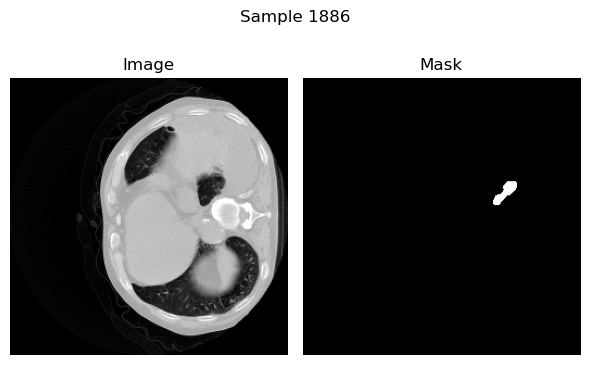

x shape: torch.Size([1, 256, 256])
y shape: torch.Size([256, 256])


In [37]:
from utils import show_pair

# show a random pair (CT image, infection mask)
sample_data = train_dataset[np.random.randint(0, len(train_dataset))]
x, y, idx = sample_data['image'], sample_data['mask'], sample_data['img_id']
show_pair(x[0], y, idx)
print(f'x shape: {x.shape}')
print(f'y shape: {y.shape}')


In [38]:
# describe image 
pd.DataFrame(x.flatten()).describe() # describe image 

,0
count,65536.000000
mean,0.287896
std,0.338638
min,0.000000
25%,0.003922
50%,0.039216
75%,0.701961
max,1.000000


In [39]:
# describe mask
pd.DataFrame(y.flatten()).describe() # describe image 

,0
count,65536.000000
mean,0.003342
std,0.057711
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<b> Show Data Split </b>

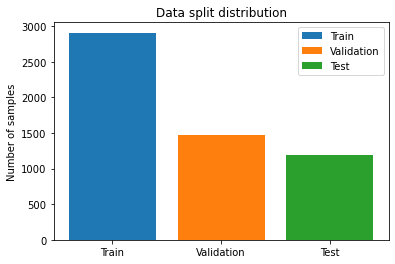

In [18]:
from utils import show_datasets

show_datasets(train_dataset, valid_dataset, test_dataset)

### Train

<b>Basic UNet-1024</b>

In [10]:
from networks import UNet, UNet_Reduced
from run_network import get_total_params

# define model
my_UNet = UNet('MyUNet', 1, 2) # output classes = 2
my_UNet.cuda()
print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

total model parameters: 1813218


<b>Reduced UNet-256</b>

In [22]:
from networks import UNet, UNet_Reduced
from run_network import get_total_params

my_UNet = UNet_Reduced('MyUNet_red_256', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

MyUNet_red_256 total model parameters: 1813218


In [40]:
# Re-create train, validation, and test dataset instances to reduce the number of samples and expedite the training process.
train_dataset = BasicDataset('PairedTrainData', n_sample=1000)
valid_dataset = BasicDataset('PairedValidData', n_sample=200)
test_dataset = BasicDataset('PairedTestData', n_sample=200)

train_dataloader = DataLoader(train_dataset, batch_size=4, num_workers=4, pin_memory=True, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, num_workers=4, pin_memory=True)

<b>Initial Weights </b>

Although we have not trained our model, we may see the output with random weights. Thus, we will pull a batch of test data loader, get the network's output, and plot it.

Sample batch 'image 'shape is: torch.Size([4, 1, 256, 256])
Sample batch 'mask' shape is: torch.Size([4, 256, 256])
Predicted mask shape is: torch.Size([4, 2, 256, 256])


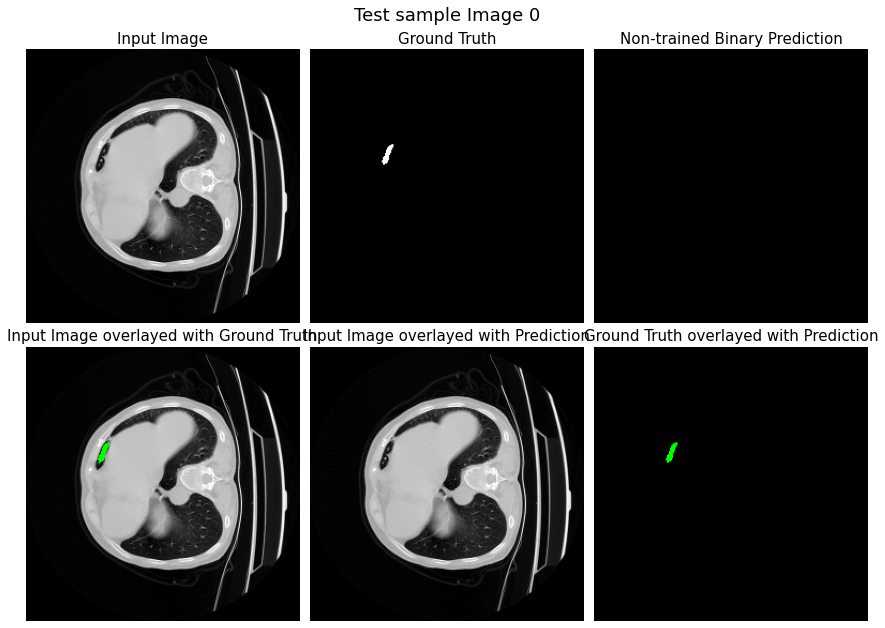

In [41]:
from utils import show_mask

show_mask(my_UNet, valid_dataloader)

### 3. Train the model

In [28]:
from run_network import get_class_weight
# lr decay 
optimizer = torch.optim.Adam(my_UNet.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.5)

# use class weight for imbalanced data
class_weights = get_class_weight(train_dataset)
class_weights = torch.tensor([1, 100], dtype=torch.float).cuda()
criteria = nn.CrossEntropyLoss(weight=class_weights)

In [32]:
from run_network import train_net

# train 
EPOCHS = 100
train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard = train_net(my_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, criteria, save_dir = model_dir)

trigger times: 0lidation Batch 50/50 - Loss: 0.443574, DICE score: 0.702240, Jaccard score: 0.541117            
EPOCH 1/100 - Training Loss: 0.324453, Training DICE score: 0.446252, Training Jaccard score: 0.308411, Validation Loss: 0.392192, Validation DICE score: 0.583881, Validation Jaccard score: 0.432504
trigger times: 0lidation Batch 50/50 - Loss: 0.382035, DICE score: 0.673232, Jaccard score: 0.507423            
EPOCH 2/100 - Training Loss: 0.324206, Training DICE score: 0.451066, Training Jaccard score: 0.313856, Validation Loss: 0.373273, Validation DICE score: 0.631563, Validation Jaccard score: 0.478396
trigger times: 1lidation Batch 50/50 - Loss: 0.431014, DICE score: 0.700908, Jaccard score: 0.539537            
EPOCH 3/100 - Training Loss: 0.323732, Training DICE score: 0.456816, Training Jaccard score: 0.318281, Validation Loss: 0.381079, Validation DICE score: 0.642995, Validation Jaccard score: 0.488791
trigger times: 2lidation Batch 50/50 - Loss: 0.384938, DICE scor

### Display results

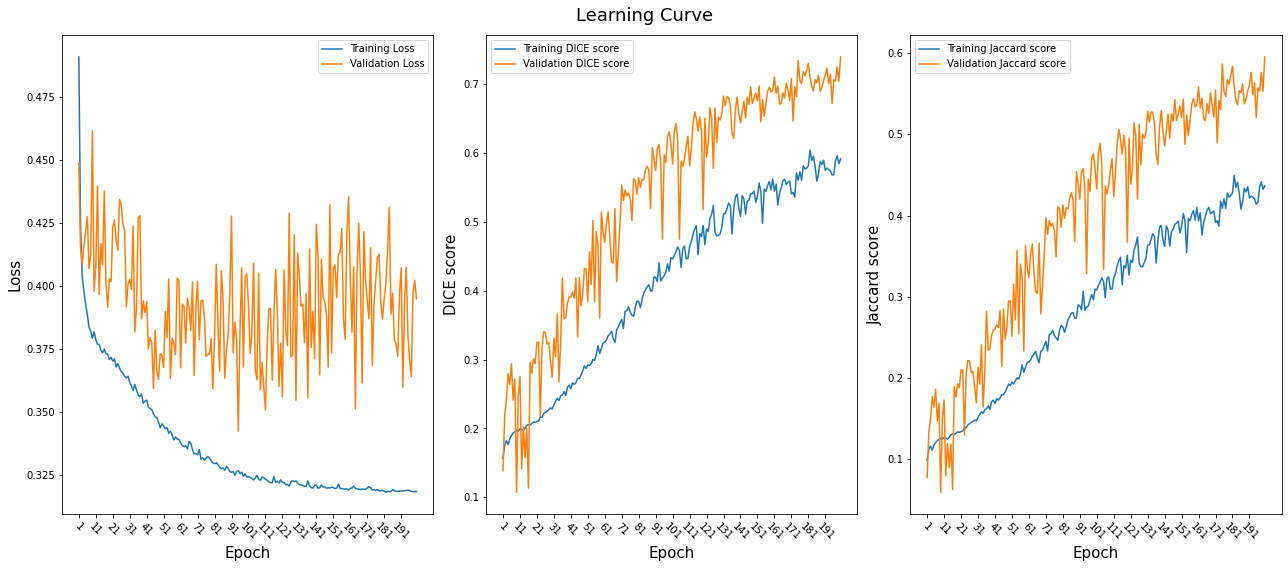

In [41]:
from run_network import show_training

show_training(EPOCHS, train_loss, valid_loss, train_dice, valid_dice, train_jaccard, valid_jaccard)

<b> Load Best Model </b>

Best epoch is epoch 185


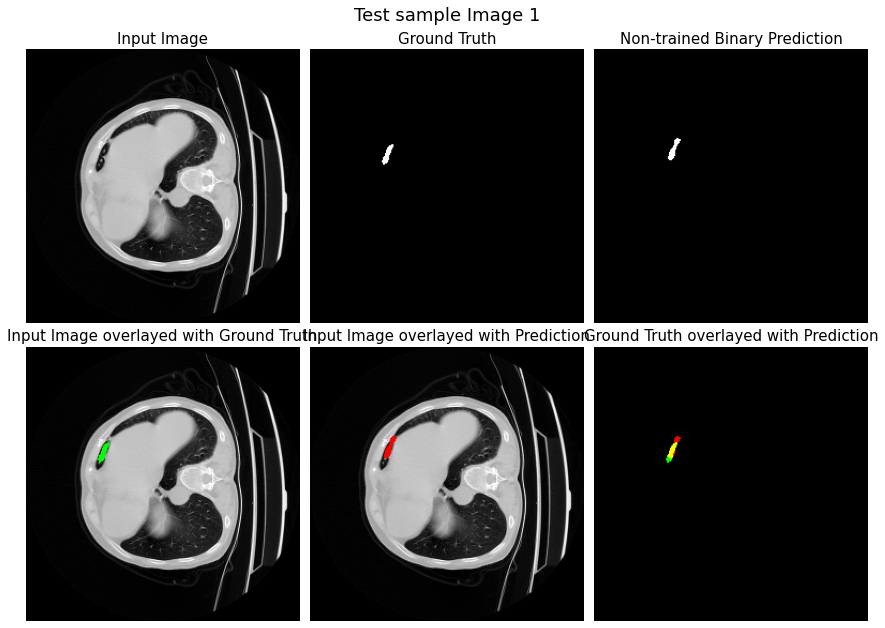

In [66]:
best_epoch = np.argmax(valid_dice) + 1 # epochs starts at 1
print(f'Best epoch is epoch {best_epoch}')

state_dict = torch.load(os.path.join(model_dir, my_UNet.name, f'epoch_{best_epoch:03}.pth'))

my_UNet.load_state_dict(state_dict)
my_UNet.cuda()

# check the performance of the best model on our previously pulled example
show_mask(my_UNet, valid_dataloader, verbose=False)

<b>Test Data </b>

In [50]:
from run_network import test_net
best_epoch = 80
state_dict = torch.load(os.path.join(model_dir, my_UNet.name, f'epoch_{best_epoch:03}.pth'))

my_UNet.load_state_dict(state_dict)
my_UNet.cuda()

# run best model on testdata
test_loss, test_dice, test_jaccard, test_accuracy, test_CM = test_net(my_UNet, test_dataloader, criteria, save_dir=model_dir)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test Jaccard score: {test_jaccard}, Test overall accuracy: {test_accuracy}')

Test Loss: 0.493017262617747, Test DICE score: 0.46605178713798523, Test Jaccard score: 0.33407023549079895, Test overall accuracy: 0.99078914642333986


Text(0.5, 69.0, 'predicted labels')

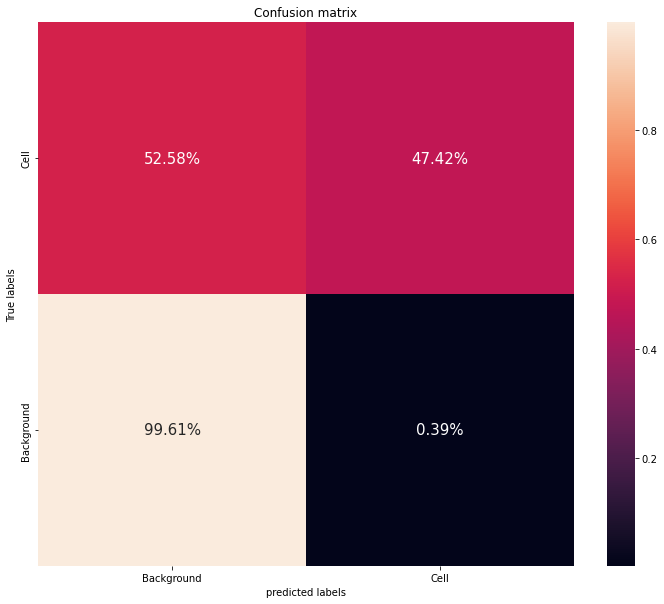

In [48]:
# confusion matrix
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2])
plt.ylabel('True labels')
plt.xlabel('predicted labels')